In [1]:
#Import necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Pre-processing and Understanding the data

### The dataset consists of 36 features, a “Target” column and 4424 student records. Features describe each student in terms of their demographic, socioeconomic status, and academic standing. Some of the demographic features are nationality, gender, age, and whether they are international student or not. Some of the socioeconomic features are marital status, father’s occupation, mother’s occupation and whether tuition fees are up to date or not. Some of the academic standing features are grade of previous degree, admission grade and grades of the first and second semesters and how many curricular credits the student acquired. All the values in the dataset are numeric except the “Target” column where values were labeled as ‘Dropout’, ‘Enrolled’, and ‘Graduate’. All features are used in this model creation.

In [2]:
df = pd.read_csv('student_data.csv', sep=';')
df.head()

Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                           122.0            1                      37   
3                           122.0            1                      38   
4                           100.0            1                      37   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      12  ...                                    0   
1                       3  ...                                    0   
2                      37  ...                                    0   
3                      37  ...                                    0   
4                      38  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP    Target  
0             1.4  1.74   Dropout  
1            -0.3  0.79  Graduate  
2             1.4  1.74   Dropout  
3            -0.8 -3.12  Graduate  
4            -0.3  0.79  Graduate  

[5 rows x 37 columns]

In [3]:
df.shape

(4424, 37)

In [4]:
df.Target.value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [6]:
df.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [7]:
#Convert Target variables to numbers
def label(row):
    if row == 'Graduate':
        return 2
    elif row =='Enrolled':
        return 1
    else:
        return 0
df['Target'] = df['Target'].apply(label)
df['Target'].value_counts()

2    2209
0    1421
1     794
Name: Target, dtype: int64

The frequency distribution of all the features and the “Target” column can be seen in the following figure. We observe that most of the features are discrete, and continuous features, such as grades columns exhibit a Gaussian distribution pattern. “Target” values are encoded as “Graduate” => 2, “Enrolled”=> 1, and “Dropout”=> 0.  The graduation rate among students is nearly three times higher than the enrollment rate and almost twice as high as the dropout rate. 

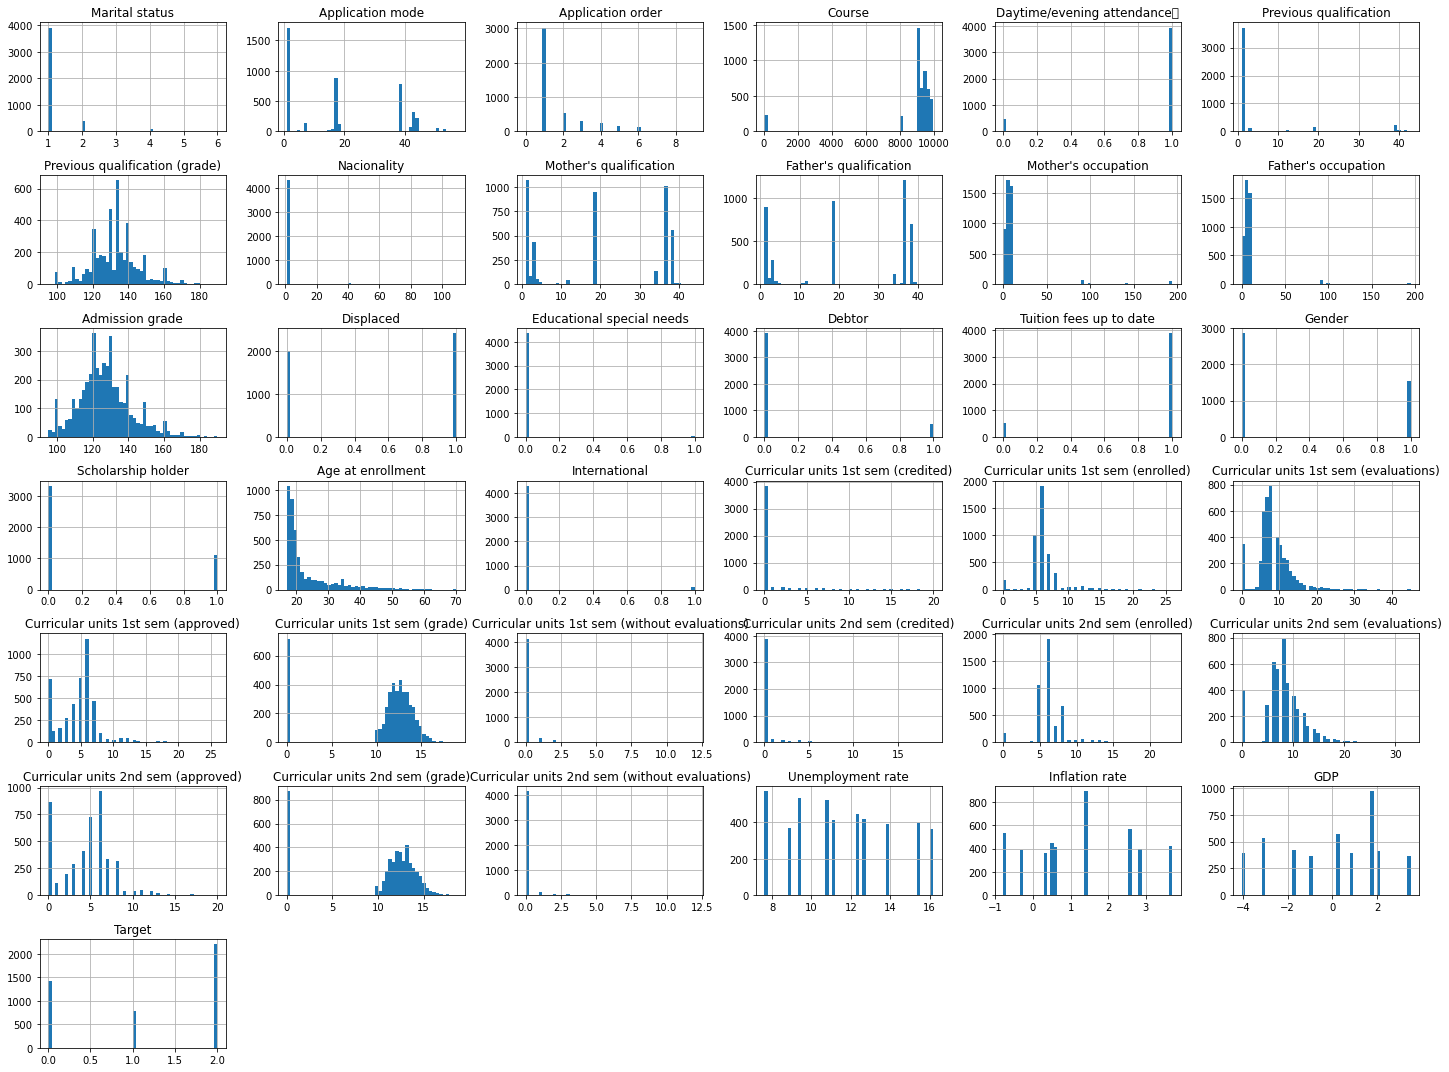

In [8]:
import matplotlib.pyplot as  plt
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

Columns that are highly correlated with Target can be seen below.The columns that exhibit high correlation with “Target” column include grades and credits students acquired in the second and first semesters, tuition and scholarship information among others. Second semester’s correlation is higher than others, as finishing the second the semester is a good indicator of how invested students are in the program.

In [9]:
corr_df = pd.DataFrame(df.corr()['Target'].abs().sort_values(ascending=False)[:16])[1:]
corr_df.index
corr_df

Target
Curricular units 2nd sem (approved)  0.624157
Curricular units 2nd sem (grade)     0.566827
Curricular units 1st sem (approved)  0.529123
Curricular units 1st sem (grade)     0.485207
Tuition fees up to date              0.409827
Scholarship holder                   0.297595
Age at enrollment                    0.243438
Debtor                               0.240999
Gender                               0.229270
Application mode                     0.221747
Curricular units 2nd sem (enrolled)  0.175847
Curricular units 1st sem (enrolled)  0.155974
Admission grade                      0.120889
Displaced                            0.113986
Previous qualification (grade)       0.103764

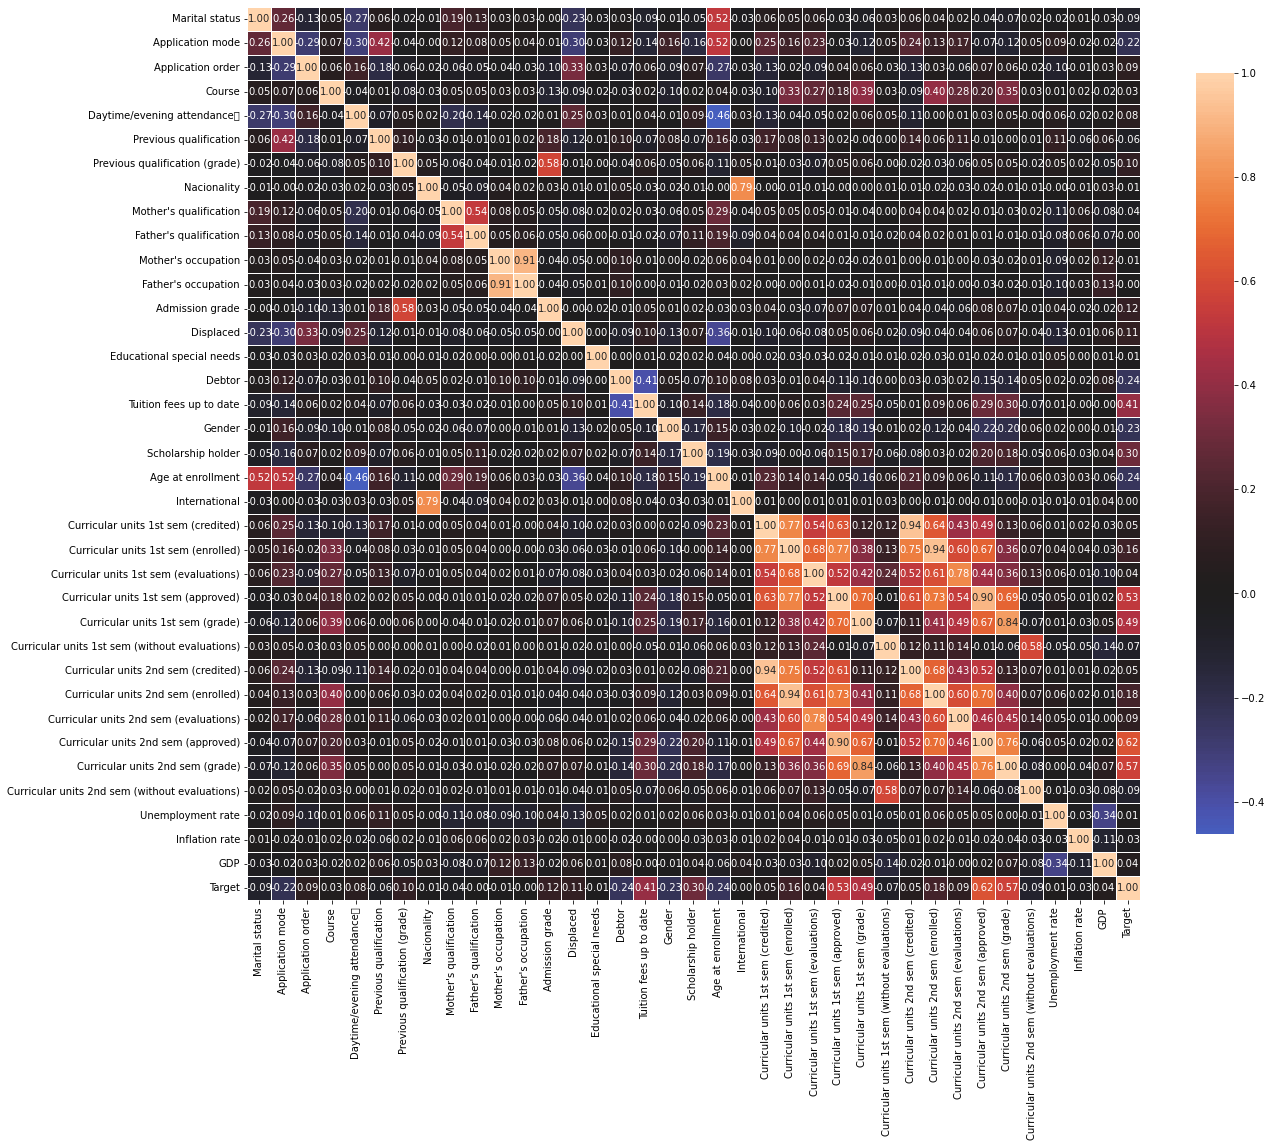

In [10]:
# Visualising correlation factors
def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

### Scaling the Dataset:

In [11]:
SS = StandardScaler()
df_scaled = pd.DataFrame(SS.fit_transform(df.iloc[:,:-1]), columns=df.columns[:-1])
df_scaled['Target'] = df['Target']
df_scaled.head()

Marital status  Application mode  Application order    Course  \
0       -0.294829         -0.095470           2.490896 -4.209520   
1       -0.294829         -0.209869          -0.554068  0.192580   
2       -0.294829         -1.010660           2.490896  0.103404   
3       -0.294829         -0.095470           0.207173  0.444115   
4        1.356212          1.162916          -0.554068 -0.408389   

   Daytime/evening attendance\t  Previous qualification  \
0                      0.350082                -0.35023   
1                      0.350082                -0.35023   
2                      0.350082                -0.35023   
3                      0.350082                -0.35023   
4                     -2.856470                -0.35023   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                       -0.804841    -0.126298               -0.036018   
1                        2.076819    -0.126298               -1.189759   
2                       -0.804841    -0.126298                1.117723   
3                       -0.804841    -0.126298                1.181819   
4                       -2.473171    -0.126298                1.117723   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0               -0.669778  ...                            -0.282442   
1               -1.256427  ...                            -0.282442   
2                0.959802  ...                            -0.282442   
3                0.959802  ...                            -0.282442   
4                1.024985  ...                            -0.282442   

   Curricular units 2nd sem (enrolled)  \
0                            -2.838337   
1                            -0.105726   
2                            -0.105726   
3                            -0.105726   
4                            -0.105726   

   Curricular units 2nd sem (evaluations)  \
0                               -2.042630   
1                               -0.522682   
2                               -2.042630   
3                                0.490616   
4                               -0.522682   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                            -1.471527                         -1.963489   
1                             0.518904                          0.659562   
2                            -1.471527                         -1.963489   
3                             0.187165                          0.416450   
4                             0.518904                          0.531608   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                       -0.199441          -0.287638   
1                                       -0.199441           0.876222   
2                                       -0.199441          -0.287638   
3                                       -0.199441          -0.813253   
4                                       -0.199441           0.876222   

   Inflation rate       GDP  Target  
0        0.124386  0.765761       0  
1       -1.105222  0.347199       2  
2        0.124386  0.765761       0  
3       -1.466871 -1.375511       2  
4       -1.105222  0.347199       2  

[5 rows x 37 columns]

### Splitting the Dataset:

X and y are what is left after removing X_test and y_test. X and y are divided into train and validation sets.

In [12]:
X_df = df_scaled.drop('Target', axis=1).values
y_df = df['Target'].values
X, X_test, y, y_test =train_test_split(X_df, y_df, test_size=0.2, random_state=21, stratify=y_df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
print('X_train shape: ', len(X_train))
print('y_train shape:', len(y_train))
print('X_val shape: ', len(X_val))
print('y_val shape:', len(y_val))
print('X_test shape: ', len(X_test))
print('y_test shape: ', len(y_test))

X_train shape:  2831
y_train shape: 2831
X_val shape:  708
y_val shape: 708
X_test shape:  885
y_test shape:  885


# Applying KNearestNeighbors:
#### Hyperparameter Tuning:

In [13]:
train_acc_knn = {}
test_acc_knn = {}
neighbors = np.arange(1, 26)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_acc_knn[neighbor] = knn.score(X_train, y_train)
    test_acc_knn[neighbor] = knn.score(X_val, y_val)

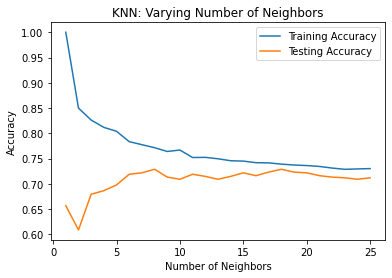

In [14]:

plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_acc_knn.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_acc_knn.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

In [15]:
print("Number of neighbors that results in the highest accuracy: {}".format(max(test_acc_knn, key=test_acc_knn.get)))

Number of neighbors that results in the highest accuracy: 8


#### Cross Validation:
##### Manual Cross Validation:

In [16]:
knn_manual = KNeighborsClassifier()

In [17]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
cv_results = cross_val_score(knn_manual, X, y, cv=kf)

In [18]:
cv_results

array([0.68135593, 0.68135593, 0.70677966, 0.70677966, 0.70677966,
       0.68590832])

In [19]:
print('Mean of cross val. results is {}, standard variation is {}'.format(np.mean(cv_results).round(4), np.std(cv_results).round(4)))

Mean of cross val. results is 0.6948, standard variation is 0.012


In [20]:
print('95% confidence interval is {}'.format(np.quantile(cv_results, [0.025, 0.975]).round(4)))

95% confidence interval is [0.6814 0.7068]


In [21]:
knn_tuned = KNeighborsClassifier(n_neighbors=18)
knn_tuned.fit(X_train, y_train)
knn_tuned.score(X_val,y_val)


0.7288135593220338

##### Grid Search:

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'n_neighbors':[8,11, 15, 18], 'metric':['euclidean', 'manhattan']}
knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn, param_grid, cv=kf)
knn_gs.fit(X_train, y_train)
print(knn_gs.best_params_, knn_gs.best_score_)


{'metric': 'manhattan', 'n_neighbors': 18} 0.7276646661805672


##### Randomized Search:

In [23]:
knn_random = RandomizedSearchCV(knn, param_grid, cv=kf, n_iter=2)
knn_random.fit(X_train, y_train)
print(knn_random.best_params_, knn_random.best_score_)

{'n_neighbors': 15, 'metric': 'manhattan'} 0.7220140719551791


Manual and grid search both give the validation accuracy at 73%. We will use the parameters found by grid search.

### Validation Results Using the Tuned KNN:

In [24]:
knn_tuned_grid = KNeighborsClassifier(n_neighbors=18, metric='manhattan')
knn_tuned_grid.fit(X_train, y_train)
knn_tuned_grid.score(X_train, y_train).round(4)

0.7549

In [25]:
knn_tuned_grid = KNeighborsClassifier(n_neighbors=18, metric='manhattan')
knn_tuned_grid.fit(X_train, y_train)
knn_tuned_grid.score(X_val, y_val).round(4)

0.7161

### Finding the most Relevant Features:

In [26]:
result = permutation_importance(knn_tuned_grid, X_val, y_val, n_repeats=10, random_state=42)
importances = result.importances_mean.round(5)
important_feat_knn = pd.DataFrame(importances, df_scaled.columns[:-1], columns=['importance'])
important_feat_knn.sort_values(by='importance', ascending=False)

importance
Curricular units 2nd sem (approved)                0.02062
Tuition fees up to date                            0.01412
Debtor                                             0.00847
Curricular units 2nd sem (evaluations)             0.00593
Scholarship holder                                 0.00551
Curricular units 1st sem (approved)                0.00395
Curricular units 2nd sem (grade)                   0.00353
Curricular units 2nd sem (credited)                0.00212
Curricular units 2nd sem (without evaluations)     0.00155
Application mode                                   0.00085
Mother's occupation                                0.00042
Marital status                                     0.00028
Educational special needs                          0.00014
Curricular units 1st sem (credited)                0.00014
Curricular units 1st sem (without evaluations)    -0.00056
Curricular units 1st sem (evaluations)            -0.00071
Father's occupation                               -0.00085
Curricular units 1st sem (grade)                  -0.00127
Inflation rate                                    -0.00184
Previous qualification (grade)                    -0.00212
Displaced                                         -0.00212
Admission grade                                   -0.00226
Age at enrollment                                 -0.00254
Nacionality                                       -0.00282
International                                     -0.00297
Mother's qualification                            -0.00381
Daytime/evening attendance\t                      -0.00395
Application order                                 -0.00395
Father's qualification                            -0.00438
GDP                                               -0.00452
Previous qualification                            -0.00480
Curricular units 1st sem (enrolled)               -0.00537
Curricular units 2nd sem (enrolled)               -0.00579
Unemployment rate                                 -0.00692
Gender                                            -0.00706
Course                                            -0.00763

<AxesSubplot:>

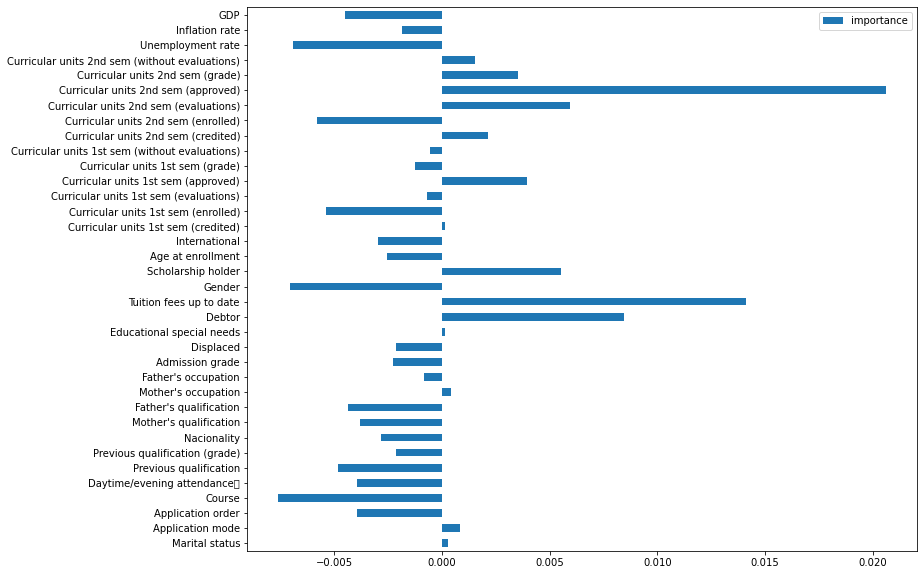

In [27]:
important_feat_knn.plot(kind='barh', figsize=(12,10))

### Applying tuned KNN to Unseen Data:

[[173  23  88]
 [ 24  34 101]
 [  6  11 425]]
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       284
           1       0.50      0.21      0.30       159
           2       0.69      0.96      0.80       442

    accuracy                           0.71       885
   macro avg       0.68      0.59      0.60       885
weighted avg       0.71      0.71      0.68       885

0.7141


<AxesSubplot:>

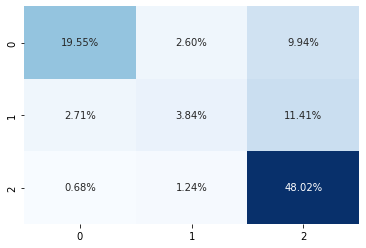

In [28]:
predicted = knn_tuned_grid.predict(X_test)
print(confusion_matrix(y_test, predicted))

print(classification_report(y_test, predicted))
print(accuracy_score(y_test, predicted).round(4))
sns.heatmap(confusion_matrix(y_test, predicted)/np.sum(confusion_matrix(y_test, predicted)), fmt='.2%',annot=True, cmap='Blues',cbar=False)

## Applying Support Vector:
##### Manual Cross Validation:

In [29]:
svm = SVC()
cv_results = cross_val_score(svm, X,y, cv=kf)


In [30]:
print('Mean of cross validation results is {}, standard variation is {}'.format(np.mean(cv_results).round(4), np.std(cv_results).round(4)))

Mean of cross validation results is 0.7601, standard variation is 0.0049


Standard deviation is pretty low, all folds give similar results, therefore no overfitting.

In [31]:
print('95% confidence interval is {}'.format(np.quantile(cv_results, [0.025, 0.975]).round(4)))

95% confidence interval is [0.7531 0.7651]


##### Grid Search:

In [32]:
svm =SVC()
params = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, param_grid=params)
searcher.fit(X_train,y_train)
pred = searcher.predict(X_val)
accuracy_score(y_val, pred)

0.769774011299435

In [33]:
searcher.cv_results_

{'mean_fit_time': array([0.2547739 , 0.25637665, 0.27944465, 0.23967824, 0.31456847,
        0.29829669, 0.31416521, 0.24366722, 0.20314403, 0.27300043,
        0.28552446, 0.22246194, 0.20078998, 0.20201421, 0.35778151]),
 'std_fit_time': array([0.00859942, 0.01243272, 0.01624658, 0.00615411, 0.00581754,
        0.03869167, 0.0266611 , 0.00634153, 0.02312599, 0.00576473,
        0.0328208 , 0.01646987, 0.01980243, 0.00523277, 0.01683956]),
 'mean_score_time': array([0.11468291, 0.10995464, 0.11213946, 0.08796506, 0.11830044,
        0.11463785, 0.14109521, 0.08603954, 0.08390303, 0.09313273,
        0.10472822, 0.08027945, 0.06948686, 0.07199845, 0.09941559]),
 'std_score_time': array([0.01200719, 0.01324775, 0.00726499, 0.003477  , 0.0041129 ,
        0.00617886, 0.02649205, 0.0041783 , 0.01895374, 0.00102238,
        0.00854064, 0.00571124, 0.00303708, 0.00082409, 0.00279602]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 10, 10, 10, 10,
                   

In [34]:
gs_svm =pd.DataFrame(searcher.cv_results_['params'])
gs_svm['test_score'] = searcher.cv_results_['mean_test_score']
gs_svm

C    gamma  test_score
0    0.1  0.00001    0.499117
1    0.1  0.00010    0.499117
2    0.1  0.00100    0.657018
3    0.1  0.01000    0.712475
4    0.1  0.10000    0.656665
5    1.0  0.00001    0.499117
6    1.0  0.00010    0.658783
7    1.0  0.00100    0.721661
8    1.0  0.01000    0.756278
9    1.0  0.10000    0.732960
10  10.0  0.00001    0.659136
11  10.0  0.00010    0.722013
12  10.0  0.00100    0.753098
13  10.0  0.01000    0.765818
14  10.0  0.10000    0.716713

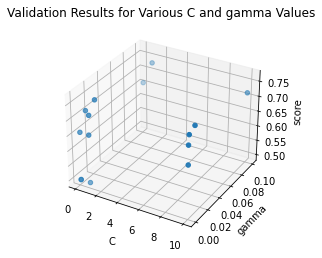

In [35]:
#Non interactive 3D
feat1 = gs_svm['C']
feat2 = gs_svm['gamma']
feat3 = gs_svm['test_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feat1, feat2, feat3)

# Set labels for each axis
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('score')

# Show the plot
plt.title('Validation Results for Various C and gamma Values')
plt.show()


In [36]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [37]:
#Plotting them in interactive form
import plotly.graph_objects as go

feat1 = gs_svm['C']
feat2 = gs_svm['gamma']
feat3 = gs_svm['test_score']

fig = go.Figure(data=[go.Scatter3d(x=feat1, y=feat2, z=feat3, mode='markers')])

fig.update_layout(scene=dict(xaxis_title='C', yaxis_title='gamma', zaxis_title='Score'), title='Validation Results for Various C and gamma Values')
fig.show()


In [38]:
searcher.best_params_

{'C': 10, 'gamma': 0.01}

In [39]:
searcher.best_score_

0.7658178622842934

### Validation Results Using Tuned SVM:

In [40]:
svm_tuned = SVC(C=10, gamma=0.01)
svm_tuned.fit(X_train, y_train)
print("Training accuracy: ", svm_tuned.score(X_train, y_train).round(4))
predicted = svm_tuned.predict(X_val)
print(confusion_matrix(y_val, predicted))
print(classification_report(y_val, predicted))
print('Validation accuracy: ', accuracy_score(y_val, predicted).round(4))

Training accuracy:  0.8516
[[169  29  29]
 [ 29  49  49]
 [  8  19 327]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       227
           1       0.51      0.39      0.44       127
           2       0.81      0.92      0.86       354

    accuracy                           0.77       708
   macro avg       0.71      0.68      0.69       708
weighted avg       0.76      0.77      0.76       708

Validation accuracy:  0.7698


### Finding the most Relevant Features:

In [41]:
result = permutation_importance(svm_tuned, X_val, y_val, n_repeats=10, random_state=42)
importances = result.importances_mean.round(5)
important_feat_svm = pd.DataFrame(importances, df_scaled.columns[:-1], columns=['importance'])
important_feat_svm.sort_values(by='importance', ascending=False)

importance
Curricular units 2nd sem (approved)                0.20042
Curricular units 1st sem (approved)                0.12429
Curricular units 2nd sem (enrolled)                0.04958
Curricular units 2nd sem (grade)                   0.04294
Tuition fees up to date                            0.03729
Curricular units 1st sem (enrolled)                0.02161
Course                                             0.02020
Age at enrollment                                  0.01271
Curricular units 1st sem (credited)                0.01215
Unemployment rate                                  0.00847
Curricular units 1st sem (evaluations)             0.00833
Mother's occupation                                0.00749
Scholarship holder                                 0.00593
Application order                                  0.00466
Previous qualification                             0.00438
Debtor                                             0.00424
Admission grade                                    0.00424
Previous qualification (grade)                     0.00424
Application mode                                   0.00353
Father's occupation                                0.00339
Father's qualification                             0.00339
Displaced                                          0.00240
Curricular units 2nd sem (credited)                0.00226
Curricular units 2nd sem (evaluations)             0.00212
Educational special needs                          0.00198
Curricular units 1st sem (grade)                   0.00169
Inflation rate                                     0.00099
GDP                                                0.00099
International                                      0.00028
Curricular units 2nd sem (without evaluations)     0.00014
Nacionality                                       -0.00042
Curricular units 1st sem (without evaluations)    -0.00141
Mother's qualification                            -0.00240
Gender                                            -0.00268
Daytime/evening attendance\t                      -0.00339
Marital status                                    -0.00353

<AxesSubplot:>

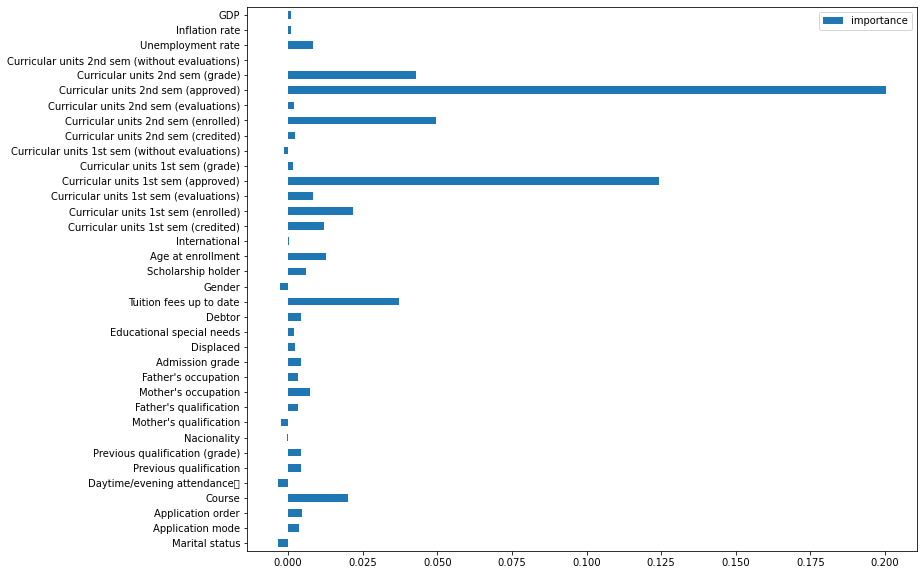

In [42]:
important_feat_svm.plot(kind='barh', figsize=(12, 10))

### Applying tuned SVM to Unseen Data:

[[204  33  47]
 [ 43  50  66]
 [ 18  27 397]]
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       284
           1       0.45      0.31      0.37       159
           2       0.78      0.90      0.83       442

    accuracy                           0.74       885
   macro avg       0.67      0.64      0.65       885
weighted avg       0.72      0.74      0.72       885

0.7356


<AxesSubplot:>

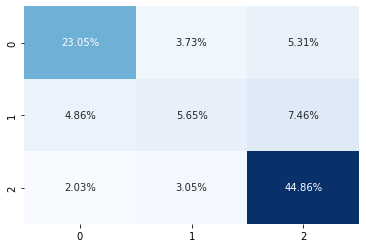

In [43]:
predicted = svm_tuned.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))
print(accuracy_score(y_test, predicted).round(4))
sns.heatmap(confusion_matrix(y_test, predicted)/np.sum(confusion_matrix(y_test, predicted)), fmt='.2%',annot=True, cmap='Blues',cbar=False)

## Applying SGDClassifier:
SGDClassifer acts like a linear SVM when using the hinge loss function. When using the log loss function it behaves like Logistic Regression Classifier. Since I already performed SVM, I will use loss:log and run Logistic Regression Classifier.

##### Manual Cross Validation:

In [44]:
sgd = SGDClassifier()
cv_results = cross_val_score(sgd, X,y, cv=kf)
print('Mean of cross validation results is {}, standard variation is {}'.format(np.mean(cv_results).round(4), np.std(cv_results).round(4)))

Mean of cross validation results is 0.7448, standard variation is 0.0094


In [45]:
print('95% confidence interval is {}'.format(np.quantile(cv_results, [0.025, 0.975]).round(4)))

95% confidence interval is [0.735 0.76 ]


##### Grid Search:

In [46]:
linear_classifier = SGDClassifier(random_state=0)

parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['log'], 'penalty':['l1','l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_val, y_val))

Best CV params {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}
Best CV accuracy 0.7576892450107003
Test accuracy of best grid search hypers: 0.7754237288135594


In [47]:
sgd_tuned = SGDClassifier(alpha=0.01, loss='log', penalty='l2')

In [48]:
gs_sgd =pd.DataFrame(searcher.cv_results_['params'])
gs_sgd['test_score'] = searcher.cv_results_['mean_test_score']
gs_sgd

alpha loss penalty  test_score
0   0.00001  log      l1    0.702930
1   0.00001  log      l2    0.700817
2   0.00010  log      l1    0.739312
3   0.00010  log      l2    0.735780
4   0.00100  log      l1    0.755565
5   0.00100  log      l2    0.755915
6   0.01000  log      l1    0.756617
7   0.01000  log      l2    0.757689
8   0.10000  log      l1    0.699755
9   0.10000  log      l2    0.742500
10  1.00000  log      l1    0.499117
11  1.00000  log      l2    0.691640

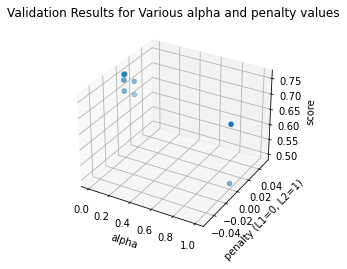

In [49]:
#Non interactive 3D
feat1 = gs_sgd['alpha']
feat2 = gs_sgd['penalty'].apply(lambda x: 0 if 'l1' else 1)
feat3 = gs_sgd['test_score']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feat1, feat2, feat3)

# Set labels for each axis
ax.set_xlabel('alpha')
ax.set_ylabel('penalty (L1=0, L2=1)')
ax.set_zlabel('score')

# Show the plot
plt.title('Validation Results for Various alpha and penalty values')
plt.show()


In [50]:
import plotly.graph_objects as go

feat1 = gs_sgd['alpha']
feat2 = gs_sgd['penalty']
feat3 = gs_sgd['test_score']

fig = go.Figure(data=[go.Scatter3d(x=feat1, y=feat2, z=feat3, mode='markers')])

fig.update_layout(scene=dict(xaxis_title='alpha', yaxis_title='penalty', zaxis_title='Score'), title='Validation Results for Various alpha and Penalty Values')
fig.show()


### Validation Results Using Tuned SGDClassifier:

In [51]:
sgd_tuned.fit(X_train, y_train)
print("Training accuracy: ", sgd_tuned.score(X_train, y_train).round(4))
predicted = sgd_tuned.predict(X_val)
print(confusion_matrix(y_val, predicted))
print(classification_report(y_val, predicted))
print("Validation accuracy: ", accuracy_score(y_val, predicted).round(4))

Training accuracy:  0.7655
[[182  11  34]
 [ 32  32  63]
 [  9   6 339]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       227
           1       0.65      0.25      0.36       127
           2       0.78      0.96      0.86       354

    accuracy                           0.78       708
   macro avg       0.75      0.67      0.68       708
weighted avg       0.77      0.78      0.75       708

Validation accuracy:  0.7811


### Finding the most Relevant Features:

In [52]:
rfe = RFE(estimator=sgd_tuned, n_features_to_select=10)
rfe.fit(X_train, y_train)
sgd_ranking = pd.DataFrame(rfe.ranking_, df_scaled.columns[:-1], columns=['Ranking'])
sgd_ranking.sort_values(by='Ranking', ascending=True)

Ranking
Curricular units 2nd sem (credited)                   1
Curricular units 2nd sem (grade)                      1
Curricular units 2nd sem (approved)                   1
Course                                                1
Curricular units 2nd sem (evaluations)                1
Curricular units 2nd sem (enrolled)                   1
Tuition fees up to date                               1
Curricular units 1st sem (enrolled)                   1
Scholarship holder                                    1
Curricular units 1st sem (approved)                   1
Curricular units 1st sem (evaluations)                2
Age at enrollment                                     3
Mother's occupation                                   4
International                                         5
Nacionality                                           6
Debtor                                                7
Curricular units 1st sem (credited)                   8
Gender                                                9
Previous qualification (grade)                       10
Mother's qualification                               11
Marital status                                       12
Admission grade                                      13
Application order                                    14
Curricular units 1st sem (without evaluations)       15
Unemployment rate                                    16
Curricular units 1st sem (grade)                     17
Displaced                                            18
Father's qualification                               19
Father's occupation                                  20
GDP                                                  21
Inflation rate                                       22
Application mode                                     23
Daytime/evening attendance\t                         24
Curricular units 2nd sem (without evaluations)       25
Previous qualification                               26
Educational special needs                            27

<AxesSubplot:>

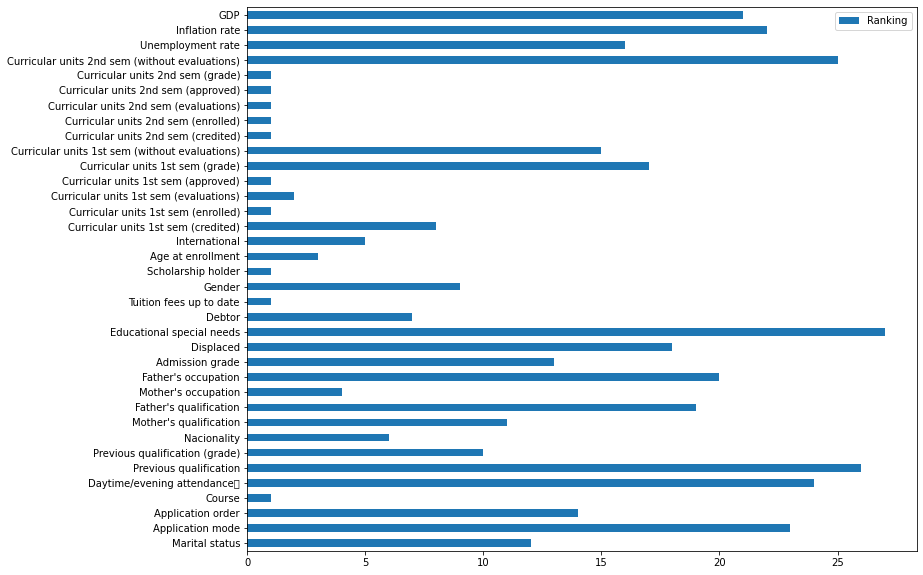

In [53]:
sgd_ranking.plot(kind='barh', figsize=(12,10))

### Applying tuned SGD to Unseen Data:

[[220  13  51]
 [ 48  30  81]
 [ 13   7 422]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       284
           1       0.60      0.19      0.29       159
           2       0.76      0.95      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.64      0.64       885
weighted avg       0.74      0.76      0.72       885

0.7593


<AxesSubplot:>

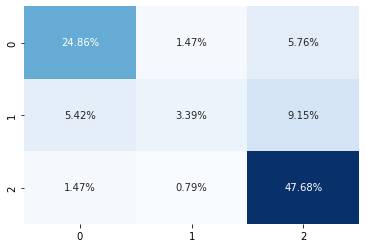

In [54]:
predicted = sgd_tuned.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))
print(accuracy_score(y_test, predicted).round(4))
sns.heatmap(confusion_matrix(y_test, predicted)/np.sum(confusion_matrix(y_test, predicted)), fmt='.2%',annot=True, cmap='Blues',cbar=False)

## Applying Random Forest Classifier:

In [55]:
rfc = RandomForestClassifier()
print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


##### Cross Validation:

In [56]:
cv_results = cross_val_score(rfc,X,y, cv=kf)
cv_results

array([0.77966102, 0.77118644, 0.76271186, 0.78531073, 0.78925035])

In [57]:
print('Mean of cross validation results is {}, standard variation is {}'.format(np.mean(cv_results).round(4), np.std(cv_results).round(4)))

Mean of cross validation results is 0.7776, standard variation is 0.0096


In [58]:
print('95% confidence interval is {}'.format(np.quantile(cv_results, [0.025, 0.975]).round(4)))

95% confidence interval is [0.7636 0.7889]


##### Grid Search

In [59]:
params = {'n_estimators':[120, 140, 160], 'max_depth':[8,10, 12], 'min_samples_leaf': [2, 3]}
rf_cv= GridSearchCV(estimator=rfc, param_grid=params, cv=3)
rf_cv.fit(X_train, y_train)
pred = rf_cv.predict(X_val)
accuracy_score(pred, y_val)

0.788135593220339

In [60]:
rf_cv.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 160}

In [61]:
gs_rf =pd.DataFrame(rf_cv.cv_results_['params'])
gs_rf['test_score'] = rf_cv.cv_results_['mean_test_score']
gs_rf

max_depth  min_samples_leaf  n_estimators  test_score
0           8                 2           120    0.756975
1           8                 2           140    0.759800
2           8                 2           160    0.764745
3           8                 3           120    0.759092
4           8                 3           140    0.765099
5           8                 3           160    0.762272
6          10                 2           120    0.763330
7          10                 2           140    0.764747
8          10                 2           160    0.766865
9          10                 3           120    0.763683
10         10                 3           140    0.762626
11         10                 3           160    0.763331
12         12                 2           120    0.762978
13         12                 2           140    0.761211
14         12                 2           160    0.763685
15         12                 3           120    0.762627
16         12                 3           140    0.761921
17         12                 3           160    0.763332

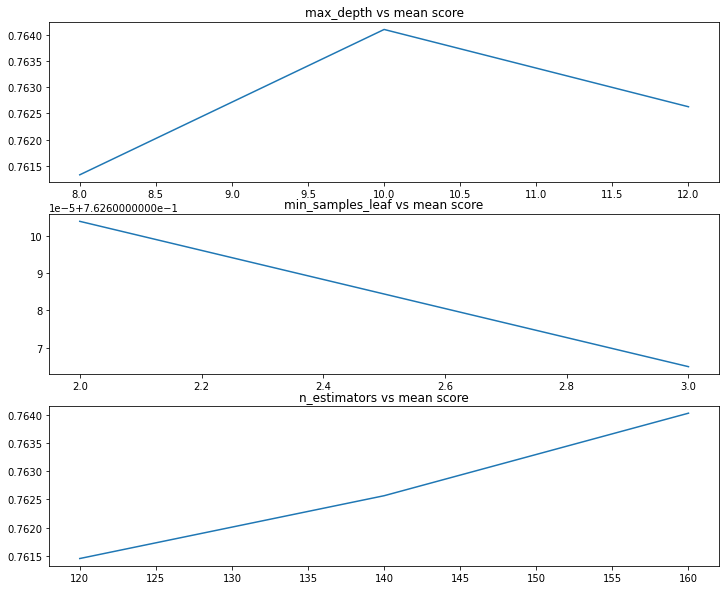

In [62]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(12,10))
ax = ax.ravel()
ax[0].plot(list(set(gs_rf['max_depth'])), [gs_rf.groupby('max_depth')['test_score'].agg(np.mean)[i] for i in set(gs_rf['max_depth'])])
ax[0].set_title('max_depth vs mean score')
ax[1].plot(list(set(gs_rf['min_samples_leaf'])), [gs_rf.groupby('min_samples_leaf')['test_score'].agg(np.mean)[i] for i in set(gs_rf['min_samples_leaf'])])
ax[1].set_title('min_samples_leaf vs mean score')
ax[2].plot(list(set(gs_rf['n_estimators'])), [gs_rf.groupby('n_estimators')['test_score'].agg(np.mean)[i] for i in set(gs_rf['n_estimators'])])
ax[2].set_title('n_estimators vs mean score')
plt.show()

### Validation Results Using Tuned Random Forest Classifier:

In [63]:
rfc_tuned = RandomForestClassifier(max_depth=12, min_samples_leaf=2, n_estimators=160)
rfc_tuned.fit(X_train, y_train)
print("Training accuracy: ", rfc_tuned.score(X_train, y_train).round(4))
predicted = rfc_tuned.predict(X_val)
print(confusion_matrix(y_val, predicted))
print(classification_report(y_val, predicted))
print("Validation accuracy: ", accuracy_score(y_val, predicted).round(4))

Training accuracy:  0.9378
[[177  19  31]
 [ 33  46  48]
 [  9  11 334]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       227
           1       0.61      0.36      0.45       127
           2       0.81      0.94      0.87       354

    accuracy                           0.79       708
   macro avg       0.74      0.70      0.71       708
weighted avg       0.77      0.79      0.77       708

Validation accuracy:  0.7867


### Finding the most Relevant Features:

<AxesSubplot:>

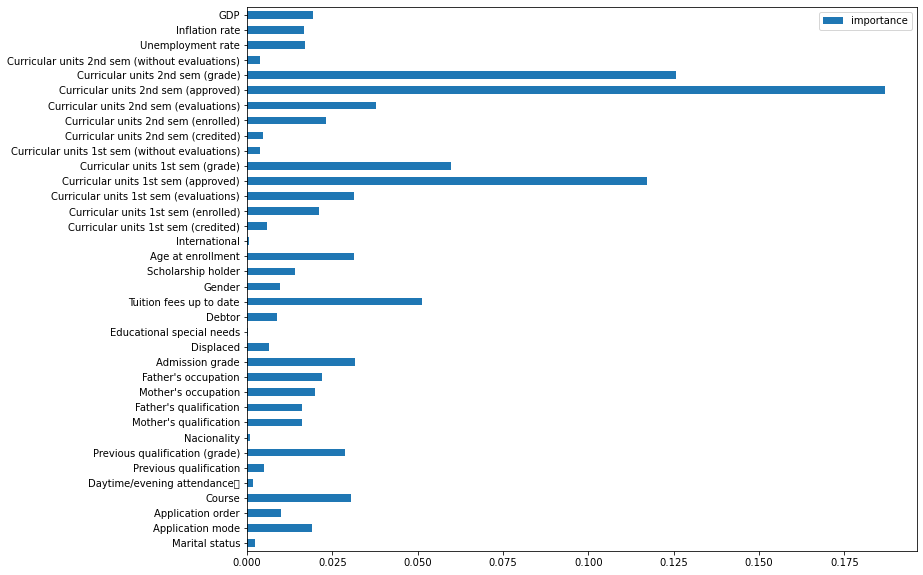

In [64]:
importances_rf = pd.DataFrame(rfc_tuned.feature_importances_, index=df_scaled.columns[:-1], columns=['importance'])
importances_rf.plot(kind='barh', figsize=(12,10))

In [65]:
importances_rf.sort_values(by='importance', ascending=False)

importance
Curricular units 2nd sem (approved)               0.186843
Curricular units 2nd sem (grade)                  0.125547
Curricular units 1st sem (approved)               0.117060
Curricular units 1st sem (grade)                  0.059889
Tuition fees up to date                           0.051290
Curricular units 2nd sem (evaluations)            0.037703
Admission grade                                   0.031679
Age at enrollment                                 0.031417
Curricular units 1st sem (evaluations)            0.031369
Course                                            0.030570
Previous qualification (grade)                    0.028760
Curricular units 2nd sem (enrolled)               0.022989
Father's occupation                               0.021952
Curricular units 1st sem (enrolled)               0.021209
Mother's occupation                               0.019833
GDP                                               0.019253
Application mode                                  0.019089
Unemployment rate                                 0.016953
Inflation rate                                    0.016611
Father's qualification                            0.016112
Mother's qualification                            0.015983
Scholarship holder                                0.013991
Application order                                 0.009870
Gender                                            0.009696
Debtor                                            0.008810
Displaced                                         0.006336
Curricular units 1st sem (credited)               0.005821
Previous qualification                            0.004928
Curricular units 2nd sem (credited)               0.004800
Curricular units 2nd sem (without evaluations)    0.003933
Curricular units 1st sem (without evaluations)    0.003797
Marital status                                    0.002441
Daytime/evening attendance\t                      0.001844
Nacionality                                       0.000976
International                                     0.000451
Educational special needs                         0.000191

### Applying tuned Random Forest to Unseen Data:

[[208  22  54]
 [ 44  42  73]
 [ 12  22 408]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       284
           1       0.49      0.26      0.34       159
           2       0.76      0.92      0.84       442

    accuracy                           0.74       885
   macro avg       0.68      0.64      0.65       885
weighted avg       0.72      0.74      0.72       885

0.7435028248587571


<AxesSubplot:>

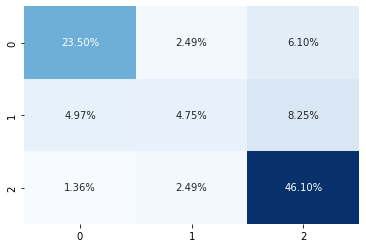

In [66]:
predicted = rfc_tuned.predict(X_test)
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))
print(accuracy_score(y_test, predicted))
sns.heatmap(confusion_matrix(y_test, predicted)/np.sum(confusion_matrix(y_test, predicted)), fmt='.2%',annot=True, cmap='Blues',cbar=False)

### Determining The Most Inluential Features for All Classifiers:

Combining Top 15 most important features of all Classifiers.

In [67]:
imp_features = pd.concat([important_feat_knn.sort_values(by='importance', ascending=False).iloc[:15,:], important_feat_svm.sort_values(by='importance', ascending=False).iloc[:15,:], sgd_ranking.sort_values(by='Ranking').iloc[:15,:], importances_rf.sort_values(by='importance', ascending=False).iloc[:15,:]], axis=1)
imp_features.columns=['KNN', "SVM", "SGD", "RF"]
imp_features.dropna(inplace=True)
imp_features

KNN      SVM  SGD        RF
Curricular units 2nd sem (approved)  0.02062  0.20042  1.0  0.186843
Tuition fees up to date              0.01412  0.03729  1.0  0.051290
Curricular units 1st sem (approved)  0.00395  0.12429  1.0  0.117060
Curricular units 2nd sem (grade)     0.00353  0.04294  1.0  0.125547
Mother's occupation                  0.00042  0.00749  4.0  0.019833

From the results in presented in table below, we observe that the least overfitting and most accurate in model in testing is SGD
Classifier which behaves like a Logistic regression model. It identifies data points belonging to"Graduate" and "Dropout" classes more accurately than others.
Cosidering none of the models done exceptionally well in this group, we conclude that SGD Classifier is best model among all.

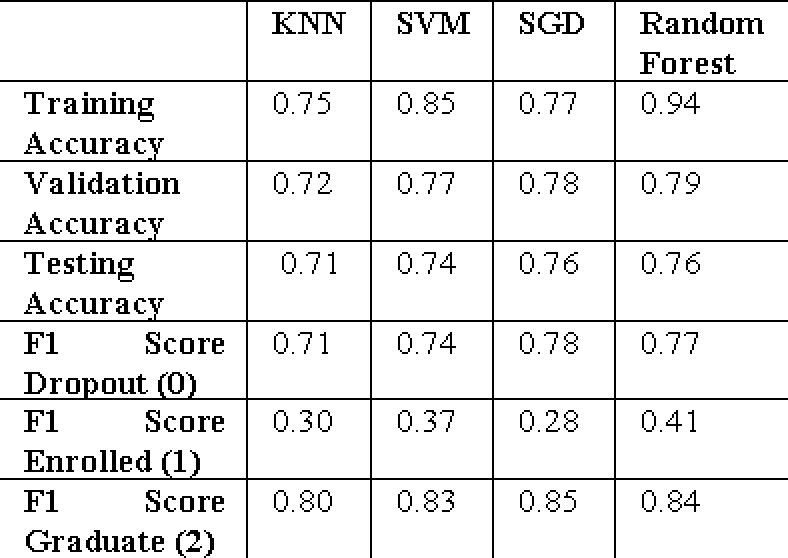